In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance

EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [20]:
data_dir = "dataset/Bank_Marketing/"
data = pd.read_csv(data_dir + "bank-additional-full.csv", sep = ';')
data = data.sample(frac=0.5, replace=True, random_state=1).reset_index(drop=True)

data['y'].replace(['yes', 'no'], [0, 1], inplace=True)

data['job'].replace(['housemaid' , 'services' , 'admin.' , 'blue-collar' , 'technician', 'retired' , 'management', 'unemployed', 'self-employed', 'unknown' , 'entrepreneur', 'student'] , [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], inplace=True)

data['education'].replace(['basic.4y' , 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown' , 'university.degree' , 'illiterate'], [1, 2, 3, 4, 5, 6, 7, 8], inplace=True)

data['marital'].replace(['married', 'single', 'divorced', 'unknown'], [1, 2, 3, 4], inplace=True)

data['default'].replace(['yes', 'no', 'unknown'],[1, 2, 3], inplace=True)

data['housing'].replace(['yes', 'no', 'unknown'],[1, 2, 3], inplace=True)

data['loan'].replace(['yes', 'no', 'unknown'],[1, 2, 3], inplace=True)

data['poutcome'].replace(['nonexistent', 'failure', 'success'], [1,2,3], inplace  = True)

labelencoder_X = LabelEncoder()
data['contact']     = labelencoder_X.fit_transform(data['contact']) 
data['month']       = labelencoder_X.fit_transform(data['month']) 
data['day_of_week'] = labelencoder_X.fit_transform(data['day_of_week']) 

data.rename(columns={'emp.var.rate' : 'emp_var_rate',
                    'cons.price.idx' : 'cons_price_idx',
                    'cons.conf.idx' : 'cons_conf_idx',
                    'nr.employed' : 'nr_employed'}, inplace=True)
y = data['y']
data = data.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33)

In [21]:
y_train.value_counts()

1    12255
0     1542
Name: y, dtype: int64

In [22]:
y_test.value_counts()

1    6061
0     736
Name: y, dtype: int64

In [23]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(13797, 20) (13797,) (6797, 20) (6797,)


# Default Model

In [24]:
model_default = svm.SVC()
scores_default = cross_val_score(model_default, X=X_train, y=y_train, cv = FOLDS)
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)
get_performance(X_test, y_test, y_pred_default)

Performance on all data
Precision: 0.8758355474056571
Recall: 0.8984846255701044
F1 Score: 0.8758577736406024


(0.8758355474056571, 0.8984846255701044, 0.8758577736406024, None)

In [25]:
pd.DataFrame(y_pred_default).value_counts()

1    6541
0     256
dtype: int64

# SMOTE Oversampling

In [26]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
model_SMOTE = svm.SVC()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)
get_performance(X_test, y_test, y_pred_SMOTE)

Performance on all data
Precision: 0.9157317340389134
Recall: 0.8340444313667794
F1 Score: 0.8592501873350099


(0.9157317340389134, 0.8340444313667794, 0.8592501873350099, None)

In [27]:
print(X_train_sm.shape,y_train_sm.shape)

(24510, 20) (24510,)


# MAPS

In [28]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [29]:
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

In [30]:
def mispredict_label(row):
    if row['y'] == row['pred']:
        return False
    return True

In [31]:
default_result_copy = default_result.copy()
X_test_copy = X_test.copy()
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)

In [32]:
# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Generate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target)

print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

MMD Spent: 27.968433618545532 BGMD Spent: 6.488950729370117


([[0.2766884531590414, 'duration>862'],
  [0.1041388518024032, 'cons_conf_idx<=-46.2 & duration>862'],
  [0.08185538881309685, 'month<=1 & duration>862']],
 [[0.41601255886970173, 'duration>587'],
  [0.2766884531590414, 'duration>862'],
  [0.09421265141318978, 'euribor3m<=0.724 & duration>383']])

In [33]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['y'])

In [34]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=upweight)

    c = Counter(weights)
    print(c.items())

    MAPS_model = svm.SVC()
    scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
    MAPS_model.fit(X_train, y_train, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0])
    recall_all.append(total_result[1])
    f1_all.append(total_result[2])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, average='weighted')
    acc_mispredicted.append(MAPS_MD_metric[0])
    recall_mispredicted.append(MAPS_MD_metric[1])
    f1_mispredicted.append(MAPS_MD_metric[2])
    
    if total_result[2] > best_f1_all:
        best_f1_all = total_result[2]
        best_weight_all = upweight;
    if MAPS_MD_metric[2] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2]
        best_weight_mis = upweight

Upweight_value:  1
dict_items([(1, 13797)])
Performance on all data
Precision: 0.8758355474056571
Recall: 0.8984846255701044
F1 Score: 0.8758577736406024
Upweight_value:  2
dict_items([(1, 11184), (2, 2613)])
Performance on all data
Precision: 0.8759098987131859
Recall: 0.8984846255701044
F1 Score: 0.8761447527398181
Upweight_value:  3
dict_items([(1, 11184), (3, 2613)])
Performance on all data
Precision: 0.8759098987131859
Recall: 0.8984846255701044
F1 Score: 0.8761447527398181
Upweight_value:  4
dict_items([(1, 11184), (4, 2613)])
Performance on all data
Precision: 0.8759488909874986
Recall: 0.8984846255701044
F1 Score: 0.8762873293346366
Upweight_value:  5
dict_items([(1, 11184), (5, 2613)])
Performance on all data
Precision: 0.8759488909874986
Recall: 0.8984846255701044
F1 Score: 0.8762873293346366
Upweight_value:  6
dict_items([(1, 11184), (6, 2613)])
Performance on all data
Precision: 0.8759890598043188
Recall: 0.8984846255701044
F1 Score: 0.8764293021407659
Upweight_value:  7
di

Performance on all data
Precision: 0.8835830547184964
Recall: 0.9015742239223187
F1 Score: 0.8862279631449066
Upweight_value:  51
dict_items([(1, 11184), (51, 2613)])
Performance on all data
Precision: 0.8835830547184964
Recall: 0.9015742239223187
F1 Score: 0.8862279631449066
Upweight_value:  52
dict_items([(1, 11184), (52, 2613)])
Performance on all data
Precision: 0.8835830547184964
Recall: 0.9015742239223187
F1 Score: 0.8862279631449066
Upweight_value:  53
dict_items([(1, 11184), (53, 2613)])
Performance on all data
Precision: 0.8835830547184964
Recall: 0.9015742239223187
F1 Score: 0.8862279631449066
Upweight_value:  54
dict_items([(1, 11184), (54, 2613)])
Performance on all data
Precision: 0.8835830547184964
Recall: 0.9015742239223187
F1 Score: 0.8862279631449066
Upweight_value:  55
dict_items([(1, 11184), (55, 2613)])
Performance on all data
Precision: 0.8835830547184964
Recall: 0.9015742239223187
F1 Score: 0.8862279631449066
Upweight_value:  56
dict_items([(1, 11184), (56, 2613)]

dict_items([(1, 11184), (100, 2613)])
Performance on all data
Precision: 0.884262260919592
Recall: 0.9018684713844343
F1 Score: 0.8870142608163009


Best weight on all is:  94
Best weight on misprediction area is:  94


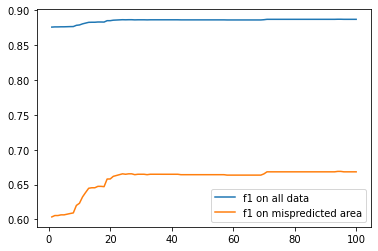

In [35]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()

In [36]:
from helper import get_mispredicted_region_test

weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=best_weight_mis)
c = Counter(weights)
MAPS_model = svm.SVC()
scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
MAPS_model.fit(X_train, y_train, sample_weight = weights)
y_pred_MAPS = MAPS_model.predict(X_test)
get_performance(X_test, y_test, y_pred_MAPS)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='y')

Performance on all data
Precision: 0.8844480513291332
Recall: 0.9020155951154921
F1 Score: 0.8871283461961567
y_actual_MD: 1277
y_predict_default_MD: 1277
y_pred_SMOTE_MD: 1277
y_pred_MAPS_MD: 1277

Default: (0.699450821446029, 0.692247454972592, 0.6035430108701276, None)
SMOTE: (0.7688201059770172, 0.5364134690681285, 0.5173712309272409, None)
MAPS: (0.6963572604653305, 0.7110415035238841, 0.6688379755146765, None)


In [37]:
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('MAPS_Bank_Marketing.csv')

# Just Train Twice

In [38]:
from helper import generate_JTT_Weights

In [39]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 29)

model_JTT = svm.SVC()
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)
get_performance(X_val, y_val, y_pred_JTT_val)

Performance on all data
Precision: 0.8579513859654228
Recall: 0.8853754940711462
F1 Score: 0.857676100655345


(0.8579513859654228, 0.8853754940711462, 0.857676100655345, None)

In [40]:
grid_upweights_JTT = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
f1_all_JTT = [];

for upweight in grid_upweights_JTT:
    weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = svm.SVC()
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    f1_all_JTT.append(total_result_JTT[2])
    if total_result_JTT[2] > best_f1_all_JTT:
        best_f1_all_JTT = total_result_JTT[2]
        best_weight_all_JTT = upweight;

Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
Performanc

JTT Best weight on all is:  10
JTT Best f1 score on all:  0.8759656665959222


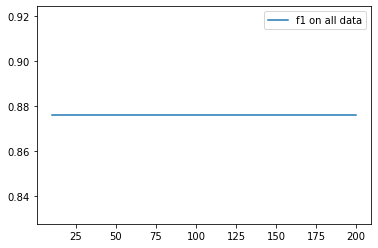

In [41]:
print("JTT Best weight on all is: ", best_weight_all_JTT)
print("JTT Best f1 score on all: ", best_f1_all_JTT)
plt.plot(grid_upweights_JTT, f1_all_JTT, label = "f1 on all data")
plt.legend()
plt.show()

In [42]:
weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = best_weight_all_JTT)
    
#combine train and validate data
weights = np.concatenate((np.ones(len(X_train_1st)), weights))
y_train_2nd = np.concatenate((y_train_1st, y_val))
X_train_2nd = pd.concat([X_train_1st, X_val])
X_train_2nd['val_weight'] = weights
X_train_2nd['target'] = y_train_2nd
X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
weights = X_train_2nd['val_weight'].to_list()
y_train_2nd = X_train_2nd['target']
X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)

model_JTT = svm.SVC()
scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
y_pred_JTT = model_JTT.predict(X_test)
total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_JTT, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='y')

Performance on all data
Precision: 0.8760982090331301
Recall: 0.8986317493011623
F1 Score: 0.8759656665959222
y_actual_MD: 1277
y_predict_default_MD: 1277
y_pred_SMOTE_MD: 1277
y_pred_MAPS_MD: 1277

Default: (0.7036068021002667, 0.6930305403288959, 0.6040511954149195, None)
SMOTE: (0.7688201059770172, 0.5364134690681285, 0.5173712309272409, None)
MAPS: (0.6963572604653305, 0.7110415035238841, 0.6688379755146765, None)
